In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from utils import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate

from IPython.display import HTML
from IPython.display import clear_output

In [12]:
# initialize random seed
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
torch.set_default_tensor_type(FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
def scatter(sample, only_final, scatter_range = [-10, 10]):
    # clear_output()
    if only_final:
        scatter = sample.detach().cpu().numpy()
        scatter_x, scatter_y = scatter[:,0], scatter[:,1]
        plt.figure(figsize=(7, 7))

        plt.xlim(scatter_range)
        plt.ylim(scatter_range)
        plt.rc('axes', unicode_minus=False)

        plt.scatter(scatter_x, scatter_y, s=5)
        # plt.show()

    else:
        step_size = sample.size(0)
        fig, axs = plt.subplots(1, step_size, figsize=(step_size * 4, 4), constrained_layout = True)
        for i in range(step_size):
            scatter = sample[i].detach().cpu().numpy()
            scatter_x, scatter_y = scatter[:,0], scatter[:,1]
            axs[i].scatter(scatter_x, scatter_y, s=5)
            axs[i].set_xlim(scatter_range)
            axs[i].set_ylim(scatter_range)
        # plt.show()

In [14]:
total_iteration = 1000
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size = 400
dataloader = torch.utils.data.DataLoader(Cluster2DataSet(dist1, dist2, probability=probability, total_len=batch_size * total_iteration), batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

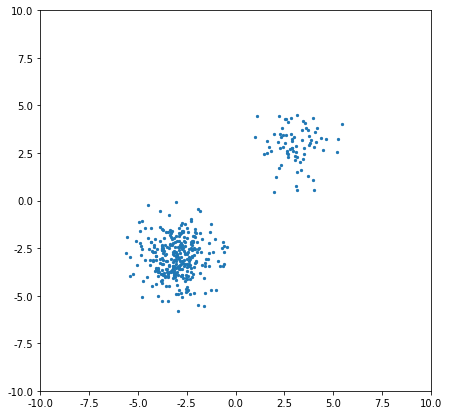

In [15]:
scatter(next(iter(dataloader)), True)

In [16]:
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True

In [17]:
learning_rate = 1e-3
z_dim = 10
sample_dir = './results/clusters2'
lamd = 10

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [18]:
model = VAE(input_size=2, h_dim=256, z_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
torch.multiprocessing.set_start_method('spawn', force=True)
# Start training
for i in range(total_iteration):
    try:
        data = dataiterator.next()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.next()
    data = data.to(device = device)

    x_reconst, mu, log_var = model(data)

    # Compute reconstruction loss and kl divergence
    # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
    # reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
    reconst_loss = F.mse_loss(x_reconst, data)
    kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Backprop and optimize
    loss = lamd*reconst_loss + kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
        print("Iteration[{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                .format(i+1, total_iteration, reconst_loss.item(), kl_div.item()))

        with torch.no_grad():
            # Save the sampled images
            z = torch.randn(batch_size, z_dim).to(device)
            out = model.decode(z)
            scatter(out, only_final, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'sampled-{}.png'.format(i+1)))
            # Save the reconstructed images
            out, _, _ = model(data)
            scatter(out, only_final, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'reconst-{}.png'.format(i+1)))
            plt.close('all')

Iteration[100/1000], Reconst Loss: 7.0128, KL Div: 0.4112


RuntimeError: mat1 dim 1 must match mat2 dim 0